In [ ]:
import os
import cv2
import numpy as np
from PIL import Image

# Define input and output folders
input_folder = r'C:\Users\vikra\Lungs_cancer\Image_processing\input folder'  # Replace with your input folder path
output_folder = r'C:\Users\vikra\Lungs_cancer/Image_processing/clahe'  # Replace with your output folder path

# Create the output folder if it doesn't exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Function to resize an image to 1024x1024
def resize_image(image, size=(1024, 1024)):
    img_pil = Image.fromarray(image)
    img_resized = img_pil.resize(size, Image.LANCZOS)
    return np.array(img_resized)

# Function to apply CLAHE
def apply_clahe(image):
    # Convert to grayscale if the image is in color
    if len(image.shape) == 3:  # If the image has 3 channels (BGR)
        img_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        img_gray = image  # The image is already grayscale

    # Create a CLAHE object with specified parameters
    clahe = cv2.createCLAHE(clipLimit=6.0, tileGridSize=(8, 8))
    img_clahe = clahe.apply(img_gray)
    return img_clahe

# Function to normalize the image
def normalize_image(image):
    # Normalize the pixel values to the range 0-255
    norm_image = cv2.normalize(image, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
    return norm_image

# Function to apply sharpening filter
def sharpen_image(image):
    # Define a sharpening kernel
    kernel = np.array([[0, -1, 0],
                       [-1, 5, -1],
                       [0, -1, 0]])
    sharpened = cv2.filter2D(image, -1, kernel)
    return sharpened

# Main processing loop
for image_name in os.listdir(input_folder):
    if image_name.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.pgm')):  # Check for valid image formats
        input_path = os.path.join(input_folder, image_name)
        output_path = os.path.join(output_folder, image_name)

        # Step 1: Read the image
        image = cv2.imread(input_path, cv2.IMREAD_COLOR)

        # Step 2: Resize the image (optional, standardize to 1024x1024)
        resized_image = resize_image(image, size=(1024, 1024))

        # Step 3: Convert to grayscale
        gray_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)

        # Step 4: Apply CLAHE
        clahe_image = apply_clahe(gray_image)

        # Step 5: Normalize the image
        normalized_image = normalize_image(clahe_image)

        # Step 6: Apply sharpening
        sharpened_image = sharpen_image(normalized_image)

        # Step 7: Save the preprocessed image
        cv2.imwrite(output_path, sharpened_image)
        print(f"Processed and saved: {output_path}")


Processed and saved: C:\Users\vikra\Lungs_cancer/Image_processing/clahe\Bengin case (1).jpg
Processed and saved: C:\Users\vikra\Lungs_cancer/Image_processing/clahe\Bengin case (10).jpg
Processed and saved: C:\Users\vikra\Lungs_cancer/Image_processing/clahe\Bengin case (100).jpg
Processed and saved: C:\Users\vikra\Lungs_cancer/Image_processing/clahe\Bengin case (11).jpg
Processed and saved: C:\Users\vikra\Lungs_cancer/Image_processing/clahe\Bengin case (12).jpg
Processed and saved: C:\Users\vikra\Lungs_cancer/Image_processing/clahe\Bengin case (13).jpg
Processed and saved: C:\Users\vikra\Lungs_cancer/Image_processing/clahe\Bengin case (14).jpg
Processed and saved: C:\Users\vikra\Lungs_cancer/Image_processing/clahe\Bengin case (15).jpg
Processed and saved: C:\Users\vikra\Lungs_cancer/Image_processing/clahe\Bengin case (16).jpg
Processed and saved: C:\Users\vikra\Lungs_cancer/Image_processing/clahe\Bengin case (17).jpg
Processed and saved: C:\Users\vikra\Lungs_cancer/Image_processing/clah

In [3]:
import os
import cv2
import numpy as np

# Define input and output folders
input_folder = r'C:\Users\vikra\Lungs_cancer\Image_processing\clahe'  # Path to CLAHE preprocessed images
output_folder = r'C:\Users\vikra\Lungs_cancer\Image_processing\segmentation'  # Output folder for segmented images

# Create the output folder if it doesn't exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Function to segment the image using the watershed method
def segment_watershed(image):
    # Ensure the input image is grayscale
    if len(image.shape) == 3:  # Convert to grayscale if the image is in color
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray_image = image

    # Apply a Gaussian blur to smooth the image
    blurred = cv2.GaussianBlur(gray_image, (5, 5), 0)

    # Apply binary thresholding
    _, binary = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Remove small noise using morphological opening
    kernel = np.ones((3, 3), np.uint8)
    opening = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel, iterations=2)

    # Identify sure background area
    sure_bg = cv2.dilate(opening, kernel, iterations=3)

    # Compute the distance transform and find sure foreground area
    dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
    _, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)

    # Identify unknown region
    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(sure_bg, sure_fg)

    # Label markers
    _, markers = cv2.connectedComponents(sure_fg)
    markers = markers + 1  # Ensure background is not labeled as 0
    markers[unknown == 255] = 0

    # Apply the watershed algorithm
    markers = cv2.watershed(cv2.cvtColor(gray_image, cv2.COLOR_GRAY2BGR), markers)

    # Highlight boundaries in the segmented image
    segmented_image = cv2.cvtColor(gray_image, cv2.COLOR_GRAY2BGR)
    segmented_image[markers == -1] = [255, 0, 0]  # Mark boundaries in red
    return segmented_image

# Main segmentation loop
for image_name in os.listdir(input_folder):
    if image_name.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.pgm')):  # Check valid formats
        input_path = os.path.join(input_folder, image_name)
        output_path = os.path.join(output_folder, image_name)

        # Step 1: Read the CLAHE preprocessed image
        image = cv2.imread(input_path, cv2.IMREAD_GRAYSCALE)

        # Step 2: Apply watershed segmentation
        segmented_image = segment_watershed(image)

        # Step 3: Save the segmented image
        cv2.imwrite(output_path, segmented_image)
        print(f"Segmented and saved: {output_path}")


Segmented and saved: C:\Users\vikra\Lungs_cancer\Image_processing\segmentation\Bengin case (1).jpg
Segmented and saved: C:\Users\vikra\Lungs_cancer\Image_processing\segmentation\Bengin case (10).jpg
Segmented and saved: C:\Users\vikra\Lungs_cancer\Image_processing\segmentation\Bengin case (100).jpg
Segmented and saved: C:\Users\vikra\Lungs_cancer\Image_processing\segmentation\Bengin case (11).jpg
Segmented and saved: C:\Users\vikra\Lungs_cancer\Image_processing\segmentation\Bengin case (12).jpg
Segmented and saved: C:\Users\vikra\Lungs_cancer\Image_processing\segmentation\Bengin case (13).jpg
Segmented and saved: C:\Users\vikra\Lungs_cancer\Image_processing\segmentation\Bengin case (14).jpg
Segmented and saved: C:\Users\vikra\Lungs_cancer\Image_processing\segmentation\Bengin case (15).jpg
Segmented and saved: C:\Users\vikra\Lungs_cancer\Image_processing\segmentation\Bengin case (16).jpg
Segmented and saved: C:\Users\vikra\Lungs_cancer\Image_processing\segmentation\Bengin case (17).jpg


In [5]:

import pandas as pd
import numpy as np
from skimage.feature import graycomatrix, graycoprops
from skimage.color import rgb2gray
from skimage.util import img_as_ubyte

# Define input folder and output CSV file paths
input_folder = r'C:\Users\vikra\Lungs_cancer\Image_processing\segmentation'  # Replace with your CLAHE output folder path
output_csv = r'C:\Users\vikra\Lungs_cancer\Image_processing\glcm_features.csv'  # Replace with your desired CSV file path

# GLCM properties to extract
GLCM_PROPERTIES = ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation', 'ASM']

# Function to extract GLCM features
def extract_glcm_features(image):
    """
    Extract GLCM features from a grayscale image.

    Parameters:
        image (numpy array): Input grayscale image.

    Returns:
        dict: Extracted GLCM features as a dictionary.
    """
    features = {}

    # Compute GLCM for 4 directions (0°, 45°, 90°, 135°)
    glcm = graycomatrix(image, distances=[1], angles=[0, np.pi/4, np.pi/2, 3*np.pi/4],
                        levels=256, symmetric=True, normed=True)

    # Extract features for each property
    for prop in GLCM_PROPERTIES:
        prop_values = graycoprops(glcm, prop)
        features[prop] = prop_values.mean()  # Average across directions

    return features

# Main processing loop to extract features
all_features = []

for image_name in os.listdir(input_folder):
    if image_name.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.pgm')):  # Check valid formats
        image_path = os.path.join(input_folder, image_name)
        print(f"Processing: {image_name}")

        # Step 1: Read the preprocessed image
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

        # Step 2: Ensure the image is 8-bit grayscale
        gray_image = img_as_ubyte(image)

        # Step 3: Extract GLCM features
        glcm_features = extract_glcm_features(gray_image)

        # Step 4: Extract label from the image name
        if "malignant" in image_name.lower():
            label = "malignant"
        elif "bengin" in image_name.lower():
            label = "bengin"
        elif "normal" in image_name.lower():
            label = "normal"
        else:
            label = "unknown"  # In case the label is not recognized
        
        # Add the label to the features dictionary
        glcm_features['Label'] = label
        
        # Append features to the list
        all_features.append(glcm_features)

# Convert features to a DataFrame and save to CSV
features_df = pd.DataFrame(all_features)
features_df.to_csv(output_csv, index=False)
print(f"GLCM features saved to {output_csv}")


Processing: Bengin case (1).jpg
Processing: Bengin case (10).jpg
Processing: Bengin case (100).jpg
Processing: Bengin case (11).jpg
Processing: Bengin case (12).jpg
Processing: Bengin case (13).jpg
Processing: Bengin case (14).jpg
Processing: Bengin case (15).jpg
Processing: Bengin case (16).jpg
Processing: Bengin case (17).jpg
Processing: Bengin case (18).jpg
Processing: Bengin case (19).jpg
Processing: Bengin case (2).jpg
Processing: Bengin case (20).jpg
Processing: Bengin case (21).jpg
Processing: Bengin case (22).jpg
Processing: Bengin case (23).jpg
Processing: Bengin case (24).jpg
Processing: Bengin case (25).jpg
Processing: Bengin case (26).jpg
Processing: Bengin case (27).jpg
Processing: Bengin case (28).jpg
Processing: Bengin case (29).jpg
Processing: Bengin case (3).jpg
Processing: Bengin case (30).jpg
Processing: Bengin case (31).jpg
Processing: Bengin case (32).jpg
Processing: Bengin case (33).jpg
Processing: Bengin case (34).jpg
Processing: Bengin case (35).jpg
Processing: 

In [7]:
import pandas as pd
df=pd.read_csv(r'C:\Users\vikra\Lungs_cancer\Image_processing\glcm_features.csv')
df

,contrast,dissimilarity,homogeneity,energy,correlation,ASM,Label
0,1543.176724,24.592116,0.180696,0.038115,0.848779,0.001456,bengin
1,1406.898463,24.094969,0.139480,0.024666,0.854747,0.000611,bengin
2,1609.164078,24.716077,0.203824,0.042176,0.851043,0.001783,bengin
3,1368.950777,23.850919,0.139819,0.024248,0.856587,0.000590,bengin
4,1321.357850,23.531732,0.138614,0.024270,0.861201,0.000591,bengin
...,...,...,...,...,...,...,...
795,1596.415539,24.893667,0.196250,0.040165,0.852627,0.001617,normal
796,1516.282522,24.364914,0.195960,0.040019,0.860586,0.001605,normal
797,1571.931022,24.615313,0.196566,0.039879,0.854529,0.001594,normal
798,10792.145721,67.594703,0.216474,0.057285,0.441456,0.003294,normal


In [9]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from joblib import dump

# Assuming you've already extracted GLCM features and have them in a DataFrame
df = pd.read_csv(r'C:\Users\vikra\Lungs_cancer\Image_processing\glcm_features.csv')  # Update the path

# Features and labels
X = df.drop(columns=['Label'])  # Drop non-feature columns like 'Label'
y = df['Label']

# Encode the target labels if they're categorical
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)  # Encode labels to 0, 1, 2 (malignant, benign, normal)

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Save the scaler to a file
dump(scaler, r'C:\Users\vikra\Lungs_cancer\Image_processing\scaler_model.joblib')

# Now you can save the data for training the model
# For example, you can save the scaled features along with labels
scaled_data = pd.DataFrame(X_scaled)
scaled_data['Label'] = y_encoded
scaled_data.to_csv(r'C:\Users\vikra\Lungs_cancer\Image_processing\scaled_features.csv', index=False)

print("Scaler saved and features scaled.")


Scaler saved and features scaled.


In [11]:
import os
print(os.getcwd())

C:\Users\vikra\Lungs_cancer\Image_processing


Random Forest Classifier:
              precision    recall  f1-score   support

           0       0.80      0.67      0.73        30
           1       1.00      1.00      1.00       120
           2       0.89      0.94      0.92        90

    accuracy                           0.94       240
   macro avg       0.90      0.87      0.88       240
weighted avg       0.94      0.94      0.94       240

Confusion Matrix for Random Forest:


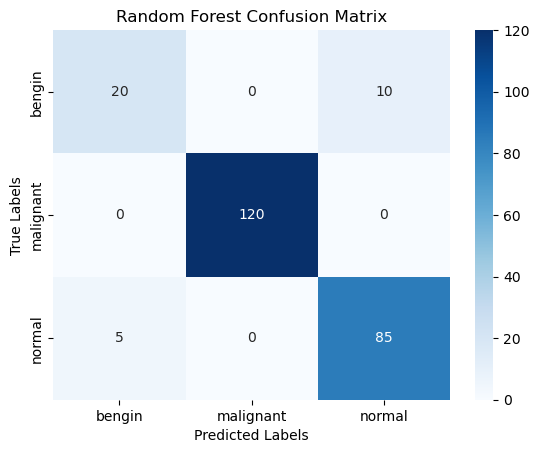

K-Nearest Neighbors Classifier:
              precision    recall  f1-score   support

           0       0.92      0.73      0.81        30
           1       1.00      1.00      1.00       120
           2       0.92      0.98      0.95        90

    accuracy                           0.96       240
   macro avg       0.94      0.90      0.92       240
weighted avg       0.96      0.96      0.96       240

Confusion Matrix for KNN:


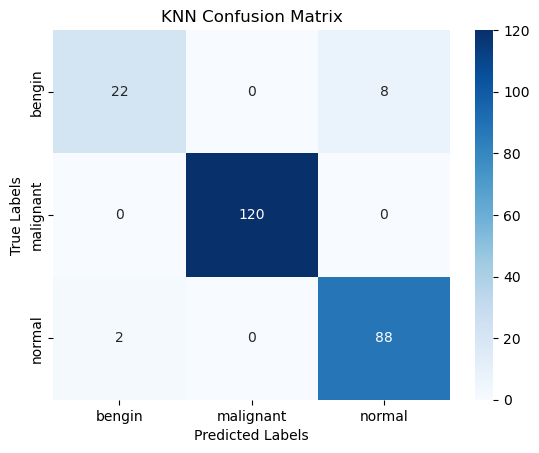

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Support Vector Machine Classifier:
Best SVM Parameters: {'C': 10, 'gamma': 1, 'kernel': 'rbf'}
              precision    recall  f1-score   support

           0       0.52      0.77      0.62        30
           1       1.00      1.00      1.00       120
           2       0.91      0.77      0.83        90

    accuracy                           0.88       240
   macro avg       0.81      0.84      0.82       240
weighted avg       0.91      0.88      0.89       240

Confusion Matrix for SVM:


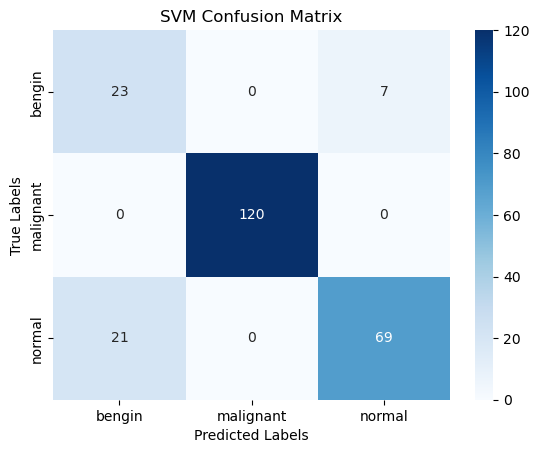

Random Forest Accuracy: 93.75%
KNN Accuracy: 95.83%
SVM Accuracy: 88.33%


In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import dump, load
import os

# Load the dataset after feature extraction
df = pd.read_csv(r'C:\Users\vikra\Lungs_cancer\Image_processing\glcm_features.csv')  # Replace with the correct path to the extracted features CSV

# Check if the 'Label' column exists for classification
if 'Label' not in df.columns:
    raise ValueError("The dataset must include a 'Label' column for classification.")

# Features and labels
X = df.drop(columns=[ 'Label','Label'])  # Drop non-feature columns like image_name and Label
y = df['Label']  # Assuming the target column is named 'Label'

# Encode the target labels if they're categorical
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)  # Encode labels to 0, 1, 2 (malignant, benign, normal)

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.3, stratify=y_encoded, random_state=60)

# Define model paths
model_path_rf = r'C:\Users\vikra\Lungs_cancer\Image_processing\rf_model.joblib'
model_path_knn = r'C:\Users\vikra\Lungs_cancer\Image_processing\knn_model.joblib'
model_path_svm = r'C:\Users\vikra\Lungs_cancer\Image_processing\svm_model.joblib'
scaler_path = r'C:\Users\vikra\Lungs_cancer\Image_processing\scaler_model.joblib'

# Random Forest Classifier
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Save Random Forest model
dump(rf_model, model_path_rf)
dump(scaler, scaler_path)  # Save scaler for later use

# Predictions and evaluation for Random Forest
y_pred_rf = rf_model.predict(X_test)
print("Random Forest Classifier:")
print(classification_report(y_test, y_pred_rf))
print("Confusion Matrix for Random Forest:")
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Random Forest Confusion Matrix")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# K-Nearest Neighbors (KNN) Classifier
knn_model = KNeighborsClassifier()
knn_model.fit(X_train, y_train)

# Save KNN model
dump(knn_model, model_path_knn)

# Predictions and evaluation for KNN
y_pred_knn = knn_model.predict(X_test)
print("K-Nearest Neighbors Classifier:")
print(classification_report(y_test, y_pred_knn))
print("Confusion Matrix for KNN:")
conf_matrix_knn = confusion_matrix(y_test, y_pred_knn)
sns.heatmap(conf_matrix_knn, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("KNN Confusion Matrix")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Support Vector Machine (SVM) Classifier with Grid Search
param_grid = {
    'C': [0.1, 1, 10],
    'gamma': [0.01, 0.1, 1],
    'kernel': ['linear', 'rbf']
}

svm_model = SVC(class_weight='balanced', random_state=42)
grid_search = GridSearchCV(svm_model, param_grid, cv=5, verbose=1, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Best SVM model
best_svm_model = grid_search.best_estimator_

# Save SVM model
dump(best_svm_model, model_path_svm)

# Predictions and evaluation for SVM
y_pred_svm = best_svm_model.predict(X_test)
print("Support Vector Machine Classifier:")
print(f"Best SVM Parameters: {grid_search.best_params_}")
print(classification_report(y_test, y_pred_svm))
print("Confusion Matrix for SVM:")
conf_matrix_svm = confusion_matrix(y_test, y_pred_svm)
sns.heatmap(conf_matrix_svm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("SVM Confusion Matrix")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Overall Accuracy
accuracy_rf = accuracy_score(y_test, y_pred_rf)
accuracy_knn = accuracy_score(y_test, y_pred_knn)
accuracy_svm = accuracy_score(y_test, y_pred_svm)

print(f"Random Forest Accuracy: {accuracy_rf * 100:.2f}%")
print(f"KNN Accuracy: {accuracy_knn * 100:.2f}%")
print(f"SVM Accuracy: {accuracy_svm * 100:.2f}%")
